# **Predicting Automobile-related Killed and Seriously Injured (KSI) Incidents in Toronto**

The aim of this project is to develop a machine learning model to analyze and identify trends in automobile-related KSI incidents within Toronto. It utilizes the Automobile-related KSI Collisions dataset (2006-2024) provided by Toronto Police Service through their Public Safety Data Portal to predict the likelihood of fatal or non-fatal Automobile-related KSI occurrences in Toronto.

# Import Libraries and Define Auxiliary Functions

In [1]:
# Pandas is a software library written in Python for data manipulation and analysis.
import pandas as pd
# NumPy is a library which provides support for large, multi-dimensional arrays, matrices and mathematical operations.
import numpy as np
# Matplotlib is a plotting library for python; pyplot offers a MATLAB-style framework for plotting.
import matplotlib.pyplot as plt
# Seaborn is a data visualization library based on matplotlib, allowing users to create complex statistical graphs.
import seaborn as sns

# Preprocessing and transformation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

# Provides tools to split data into training and testing sets and perform hyperparameter tuning with cross-validation
from sklearn.model_selection import train_test_split, GridSearchCV

# Pipeline class allows users to chain together multiple preprocessing and modeling steps
from sklearn.pipeline import Pipeline

# SMOTE is a method used to handle class imbalance in datasets by generating samples of minority classes.
from imblearn.over_sampling import SMOTE

# Function to evaluate a trained classification model using key metrics and visualize its ROC curve
def evaluate_model(model, X_test, y_test, X_full=None, y_full=None, title="Model"):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
    from sklearn.model_selection import cross_val_score

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n--- {title} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    if X_full is not None and y_full is not None:
        cv_scores = cross_val_score(model, X_full, y_full, cv=3, scoring='accuracy')
        print("\nCross-Validation Scores:", cv_scores)
        print("Mean CV Accuracy:", np.mean(cv_scores))
        print("Standard Deviation:", np.std(cv_scores))

    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="#4c72b0", lw=2.5, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="#7f7f7f", linestyle="--", linewidth=1.5)
    plt.xlabel("False Positive Rate", fontsize=12, fontweight='bold')
    plt.ylabel("True Positive Rate", fontsize=12, fontweight='bold')
    plt.title(f"ROC Curve for {title} Classifier", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, linestyle='--')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# *Exploratory Data Analysis (EDA)*

This section loads the dataset and performs initial data inspection, including:
- Checking dataset dimensions and column names
- Reviewing data types, missing values, and summary statistics
- Inspecting unique values in categorical columns
- Visualizing distributions of key categorical features

Dataset Dimensions (Rows, Columns): (17230, 54)

List of Column Names: Index(['OBJECTID', 'INDEX', 'ACCNUM', 'DATE', 'TIME', 'STREET1', 'STREET2',
       'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'LATITUDE', 'LONGITUDE', 'ACCLOC',
       'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE',
       'INVTYPE', 'INVAGE', 'INJURY', 'FATAL_NO', 'INITDIR', 'VEHTYPE',
       'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND',
       'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST',
       'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH',
       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140',
       'DIVISION', 'x', 'y'],
      dtype='object')

Unique values per column:
OBJECTID             17230
INDEX                17230
ACCNUM                4392
DATE                  3827
TIME                  1314
STREET1               1766
STREET2        

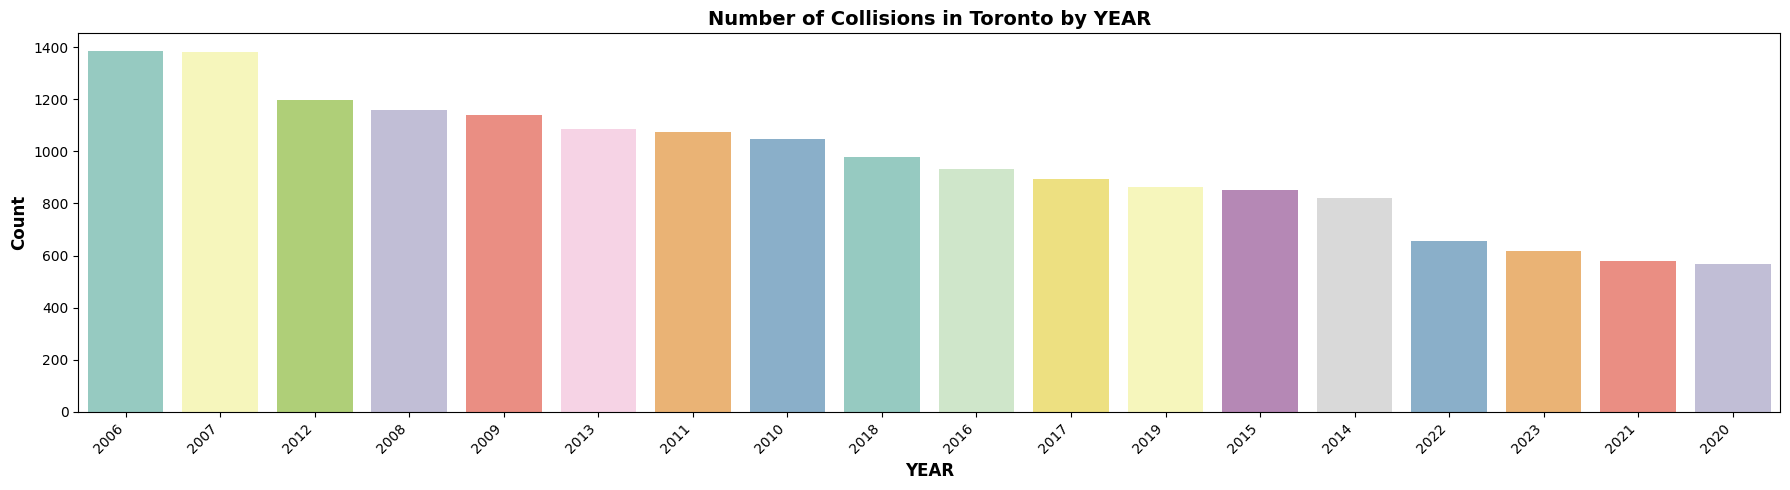

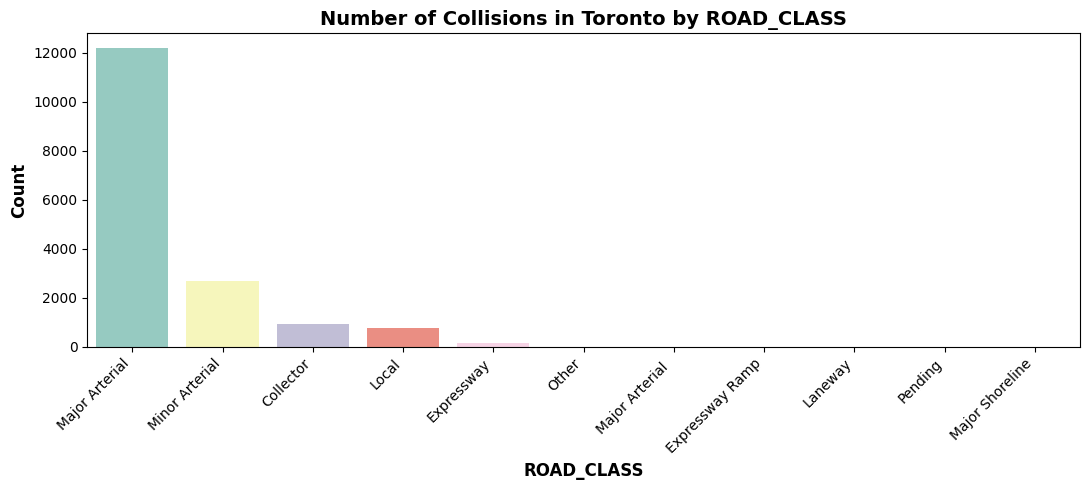

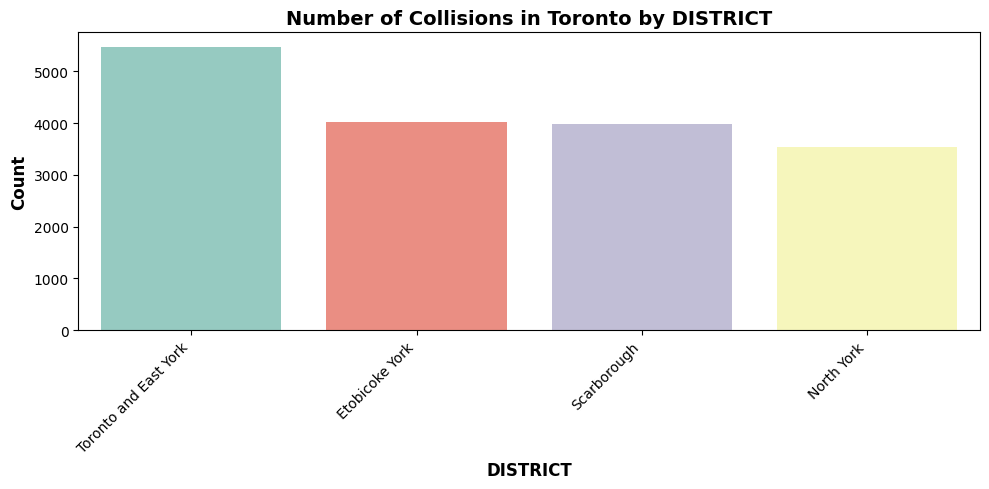

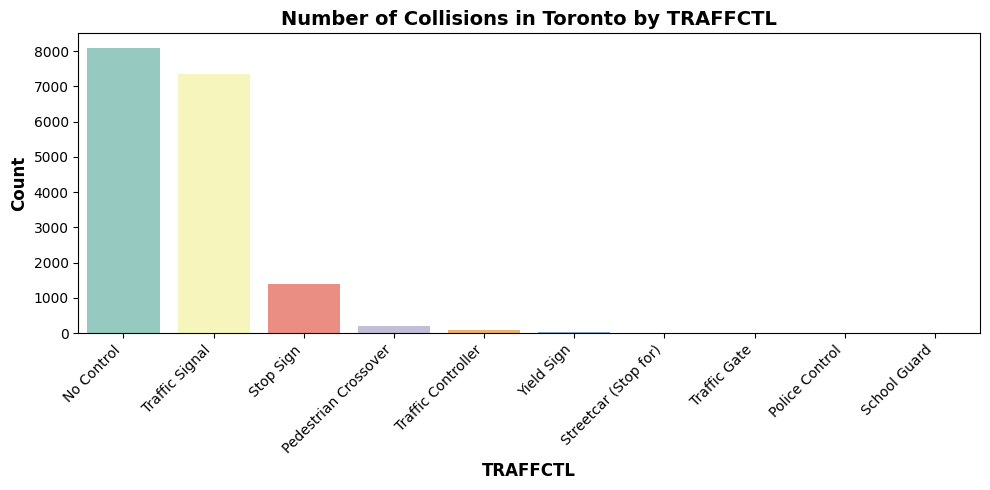

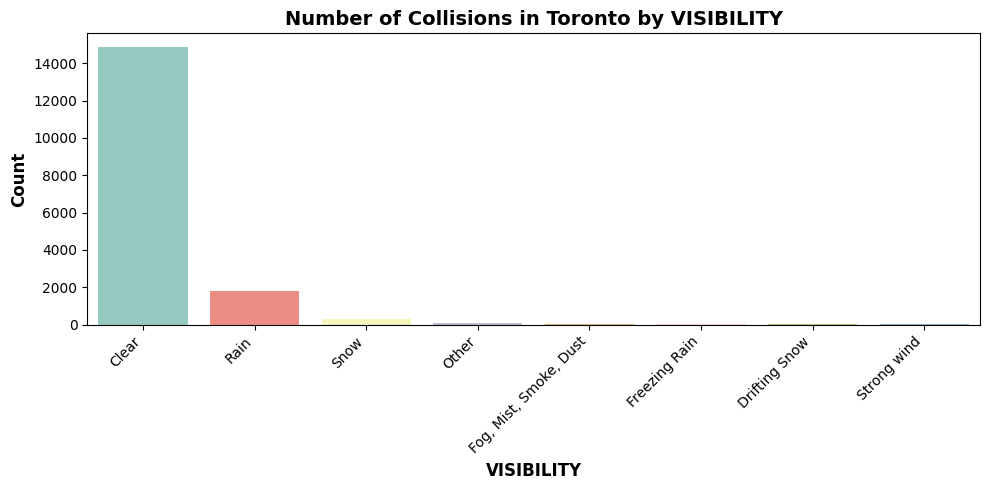

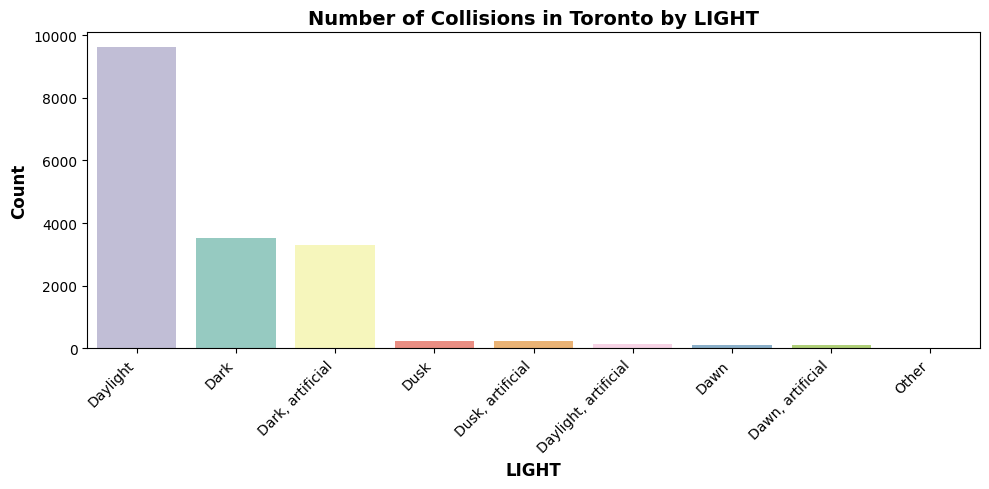

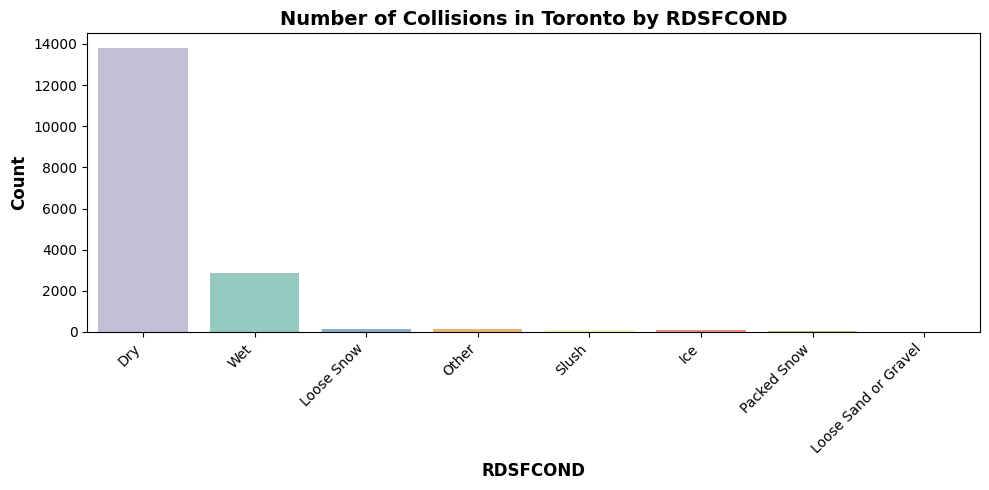

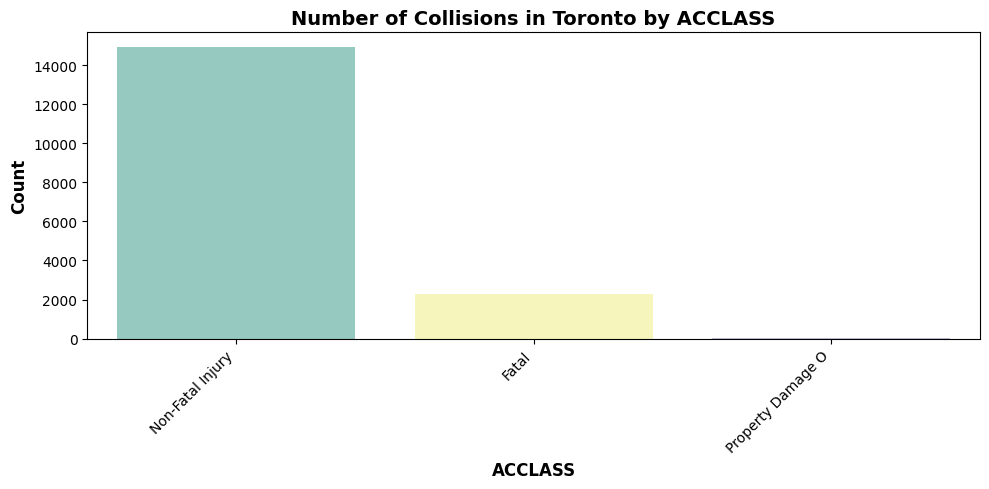

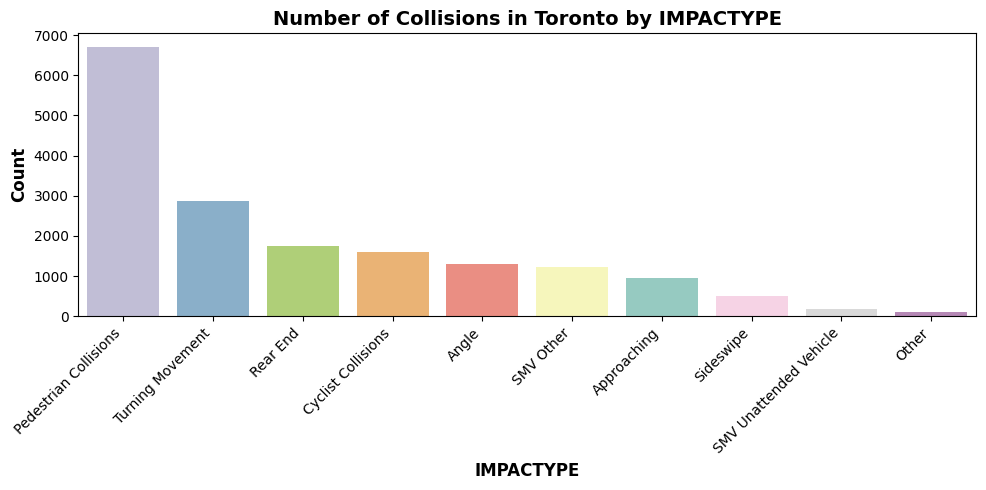

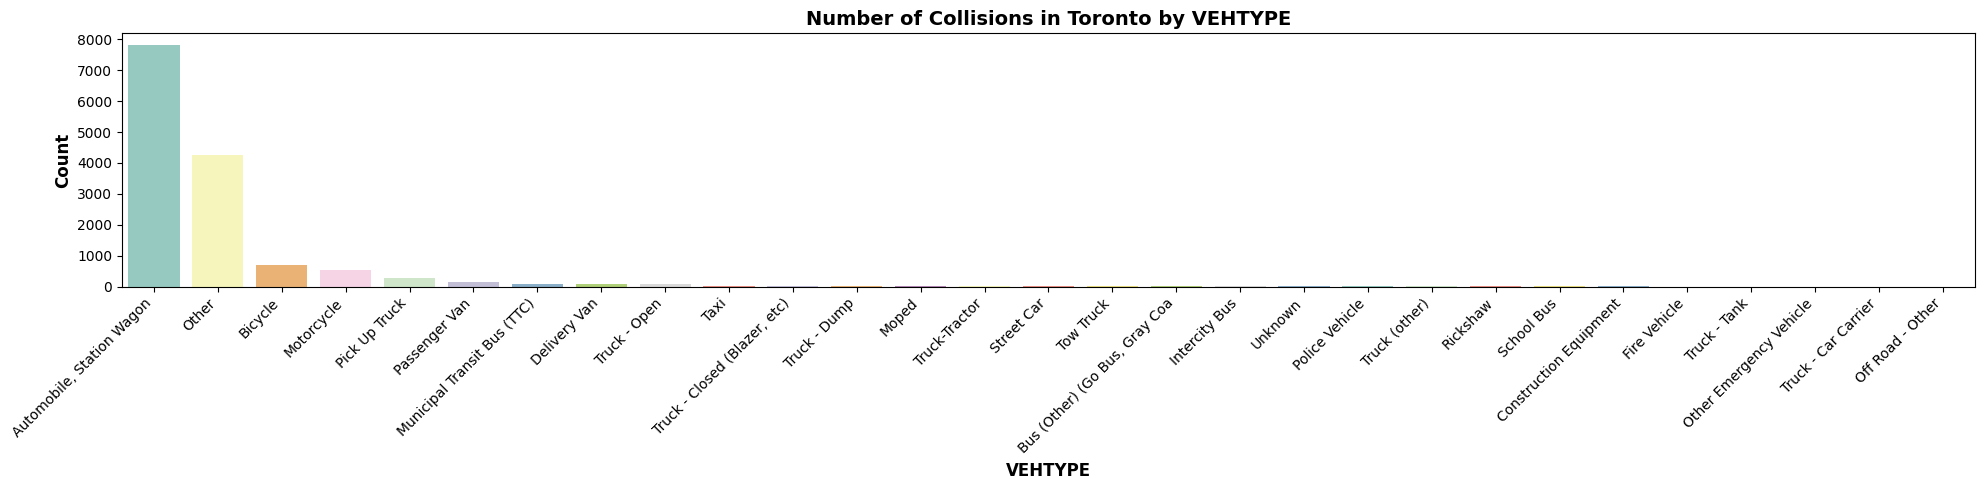

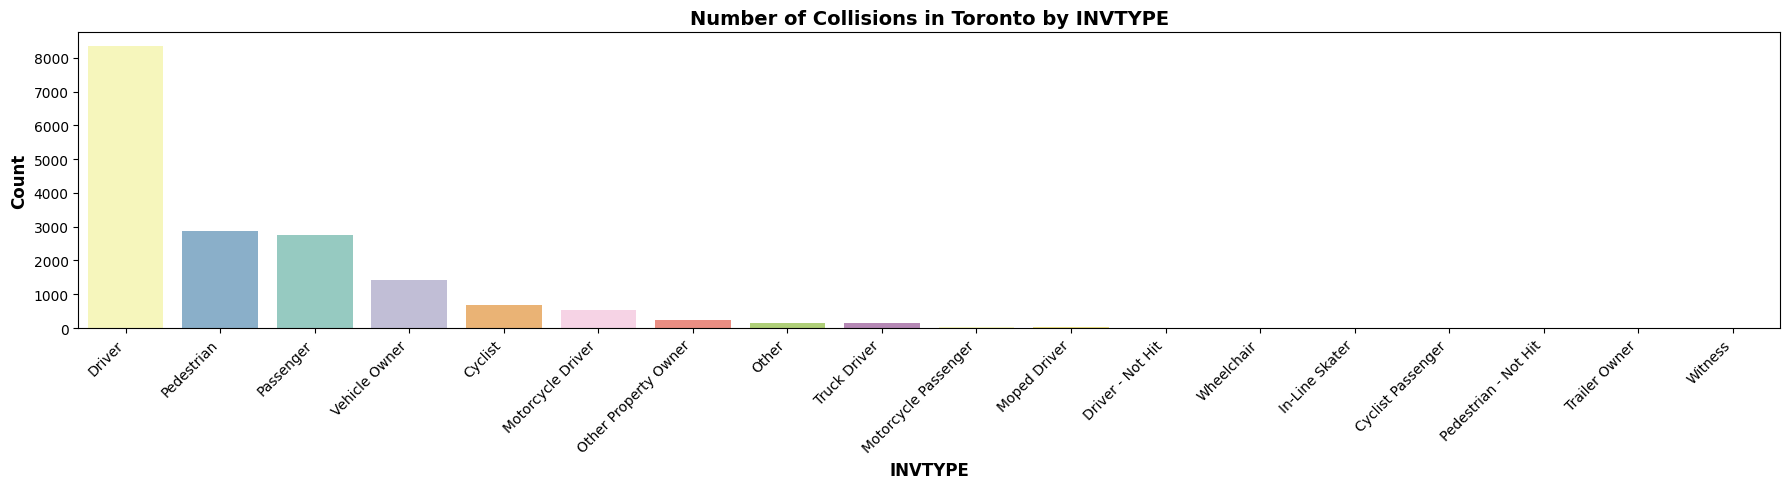

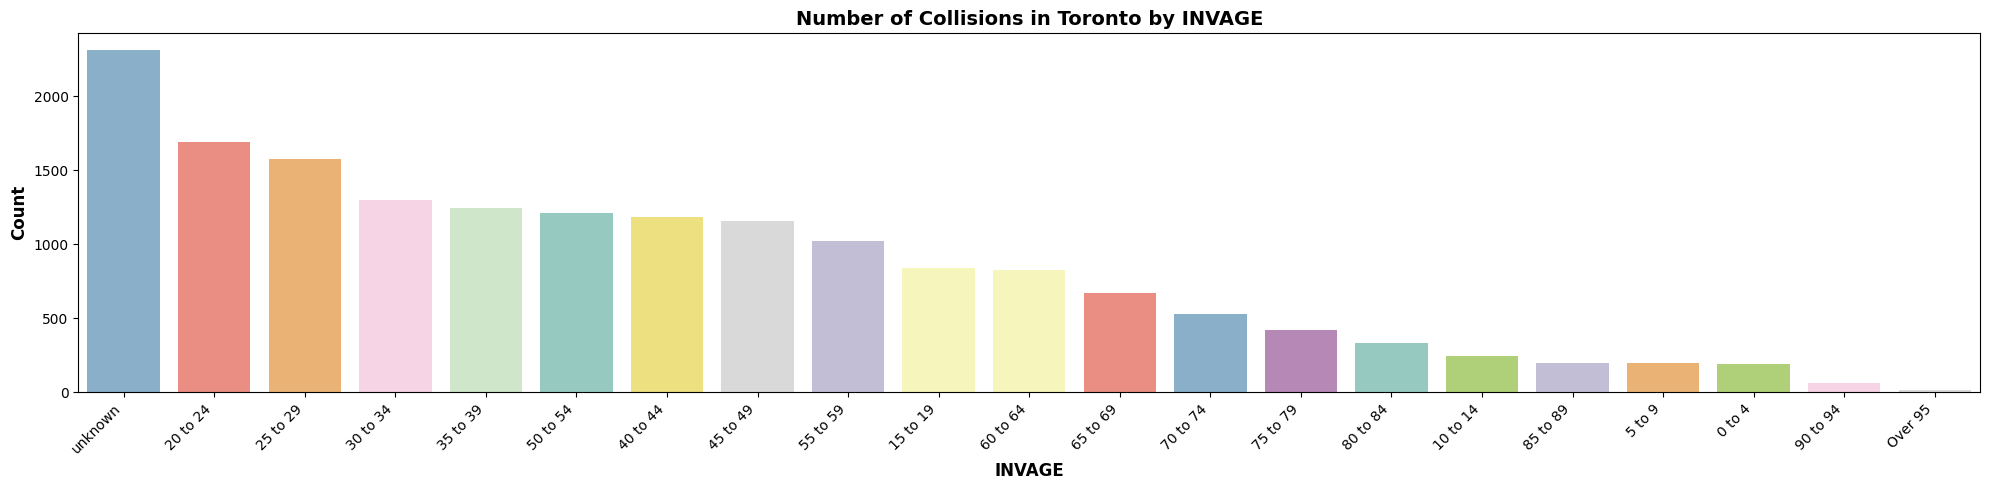

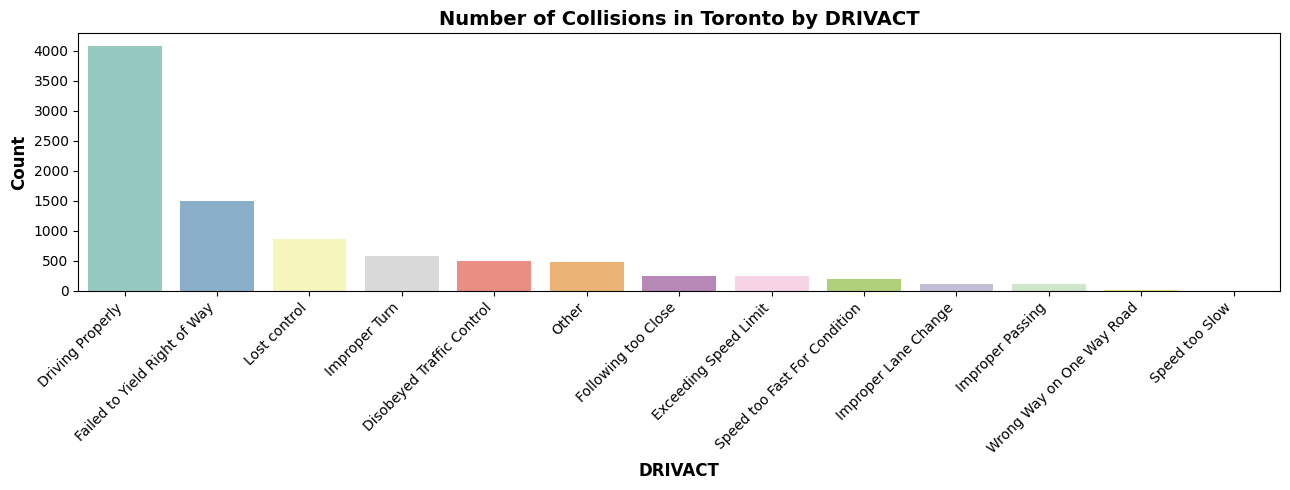

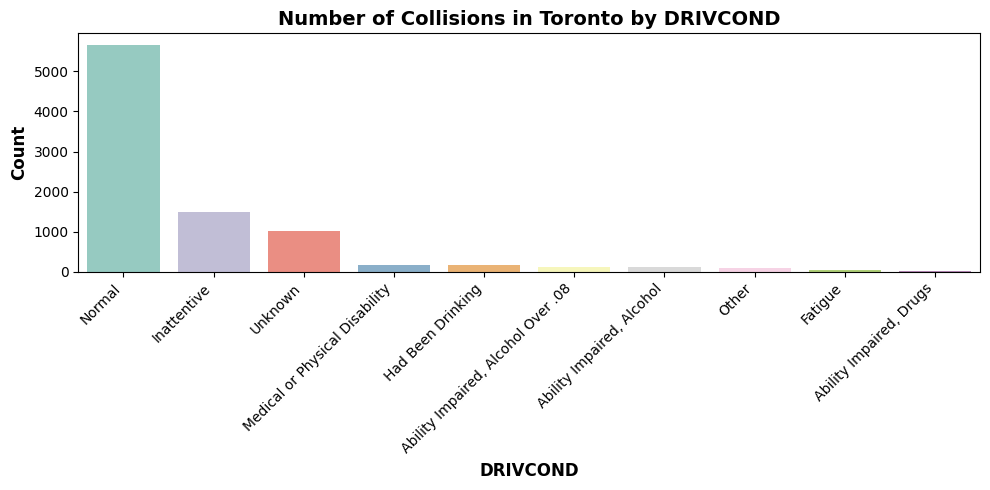

In [2]:
# Load the CSV dataset file
df = pd.read_csv("Automobile_KSI_Collisions.csv")

# Dataset description 
print("Dataset Dimensions (Rows, Columns):", df.shape)
print("\nList of Column Names:", df.columns)

# Display all unique values in a column.
print("\nUnique values per column:")
print(df.nunique())

print("\nData Types & Non-Null (Missing) Value Counts:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nExtracting Unique Values from Categorical Columns:")
for col in df.select_dtypes(include='object'):
    print(f"\n{col}:")
    print(df[col].unique())

# Identify Missing Values
print("\n")
print(df.isnull().sum())

# Convert DATE to datetime and extract YEAR, MONTH, DAY
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['WEEKDAY'] = df['DATE'].dt.weekday

# Visualize key categorical features
visualize = [
    'YEAR', 'ROAD_CLASS', 'DISTRICT', 'TRAFFCTL', 'VISIBILITY',
    'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'VEHTYPE',
    'INVTYPE', 'INVAGE', 'DRIVACT', 'DRIVCOND',
]
palette_color = "Set3"

# Generate count plots for each column
for col in visualize:
    if col in df.columns:
        n_unique = df[col].nunique()
        plt.figure(figsize=(max(10, min(n_unique, 20)), 5))  # Adjusts width based on # of categories
        sns.countplot(data=df, x=col, hue=col, order=df[col].value_counts().index, palette=palette_color, legend=False)
        plt.title(f'Number of Collisions in Toronto by {col}', fontweight='bold', fontsize=14)
        plt.xlabel(col, fontweight='bold', fontsize=12)
        plt.ylabel('Count', fontweight='bold', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.tight_layout()
        plt.show()

# *Data Cleaning*

- Reclassifying `"Property Damage Only"` entries as `"Non-Fatal Injury"` to support binary classification  
- Filtering the dataset to include only `"Fatal"` and `"Non-Fatal Injury"` cases  
- Filling missing values in binary categorical columns (e.g., PEDESTRIAN, ALCOHOL) with `"No"`  
- Dropping irrelevant or redundant columns
- Applying label encoding to convert the target column (`ACCLASS`) into a binary numeric format

In [3]:
# Replace 'Property Damage Only' with 'Non-Fatal Injury' to create binary classification
df['ACCLASS'] = df['ACCLASS'].replace('Property Damage Only', 'Non-Fatal Injury')

# Filter only 'Fatal' and 'Non-Fatal Injury'
df = df[df['ACCLASS'].isin(['Fatal', 'Non-Fatal Injury'])].copy()
     
# Fill 'Yes/No' fields with 'No' where there is missing value
binary_col = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE',
              'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER', 
              'SPEEDING','AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY']
df[binary_col] = df[binary_col].fillna('No')

# Remove irrelevant or unused columns
remove_col = ['OBJECTID', 'INDEX', 'ACCNUM', 'DATE', 'TIME', 'STREET1', 
              'STREET2', 'OFFSET', 'ACCLOC', 'FATAL_NO', 'PEDTYPE', 
              'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 
              'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 
              'x', 'y']

df = df.drop(columns=[col for col in remove_col if col in df.columns])

# Encode target labels: Fatal = 0, Non-Fatal = 1
label_encoder = LabelEncoder()
df['ACCLASS'] = label_encoder.fit_transform(df['ACCLASS'])

print("Fatal vs Non-Fatal Distribution (%):")
print(df['ACCLASS'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

# Split dataset into x (input features) and y (target collision severity)
X = df.drop('ACCLASS', axis=1)
y = df['ACCLASS']

Fatal vs Non-Fatal Distribution (%):
ACCLASS
1    86.73%
0    13.27%
Name: proportion, dtype: object


# *Model Building*

In this step, we build and evaluate three classification models: Random Forest, Logistic Regression, and XGBoost. Each model is trained using a preprocessing pipeline that includes imputation for missing values, categorical encoding, and feature scaling. To help the models better detect fatal KSI cases, SMOTE (Synthetic Minority Over-sampling Technique) is applied to balance the dataset. Additionally, hyperparameters are tuned using grid search with cross-validation. Model performance is assessed using standard evaluation metrics, including Accuracy, Precision, Recall, F1 Score, and ROC AUC.

# *1. Logistic Regression Model*

This section builds a Logisitc Regression model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:
- Accuracy: 80.04% — Solid overall performance
- Precision: 94.67% — Effectively identifies fatal cases with few false positives
- F1 Score: 87.64% — Good balance between precision and recall
- Recall: 81.58% — Captures the majority of fatal cases
- ROC AUC Score: 0.853 — Strong ability to distinguish between fatal and non-fatal outcomes

Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Logistic Regression Evaluation ---
Accuracy: 0.800464711007842
Precision: 0.9467547609794015
F1 Score: 0.8764166216945494
Recall: 0.8158070997990623
Confusion Matrix:
 [[ 320  137]
 [ 550 2436]]

Cross-Validation Scores: [0.90503572 0.90676194 0.88794005]
Mean CV Accuracy: 0.8999125690879222
Standard Deviation: 0.008495131478230264
ROC AUC Score: 0.8532993502867502


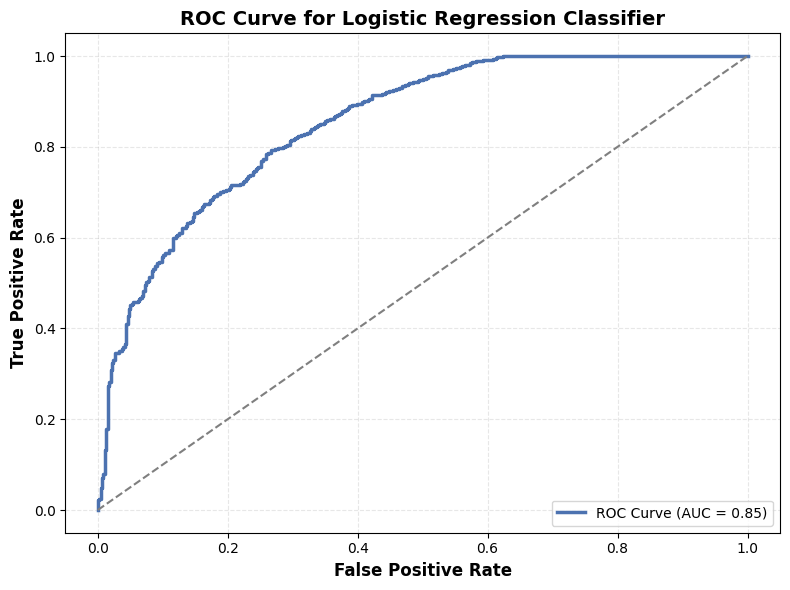

In [4]:
from sklearn.linear_model import LogisticRegression

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include='object')),
    ('num', num_pipeline, selector(dtype_exclude='object'))
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Logistic Regression setup
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, solver='lbfgs', penalty='l2'))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear'],
    'logreg__penalty': ['l2']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid_search.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
logreg_model = grid_search.best_estimator_

# Call upon the evaluation function to assess Logistic Regression model performance
evaluate_model(logreg_model, X_test, y_test, X_full=X_processed, y_full=y, title="Logistic Regression")

# *2. Random Forest Classifier*

This section builds a Random Forest classification model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:
- Accuracy: 93.63% - Strong overall correctness
- Precision: 94.07% — Low rate of false positives for fatal cases
- F1 Score: 96.42% — High balance of precision and recall
- Recall: 98.89% — Nearly all fatal cases were correctly identified
- ROC AUC Score: 0.926 — High ability to distinguish between fatal and non-fatal outcomes

Fitting 3 folds for each of 6 candidates, totalling 18 fits

--- Random Forest Evaluation ---
Accuracy: 0.9363926808016265
Precision: 0.9407454603376871
F1 Score: 0.9642448979591837
Recall: 0.9889484259879437
Confusion Matrix:
 [[ 271  186]
 [  33 2953]]

Cross-Validation Scores: [0.90747517 0.91199024 0.25548972]
Mean CV Accuracy: 0.6916517093546014
Standard Deviation: 0.3084186102332112
ROC AUC Score: 0.9260004015822928


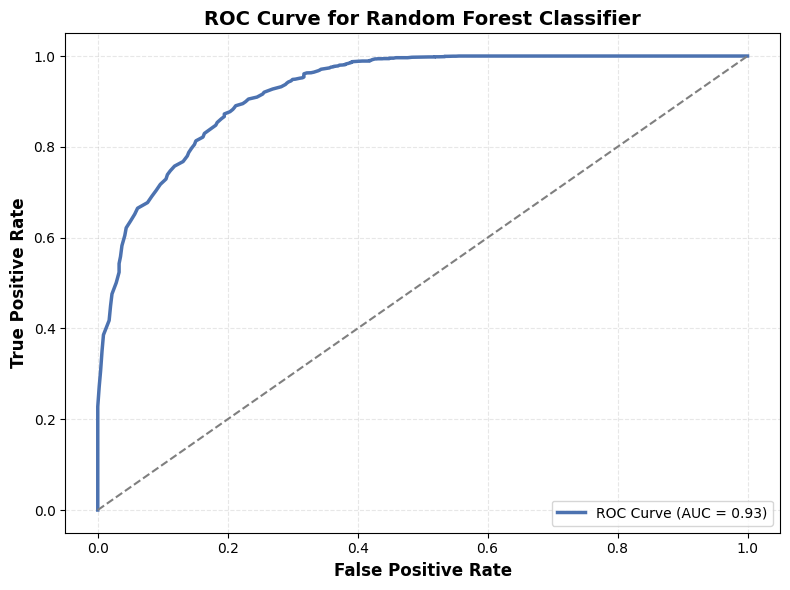

In [5]:
from sklearn.ensemble import RandomForestClassifier

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include='object')),
    ('num', num_pipeline, selector(dtype_exclude='object'))
])

# Apply preprocessing
X_rf_processed = preprocessor.fit_transform(X)

rf_temp = RandomForestClassifier(random_state=13, n_jobs=-1, class_weight='balanced')
rf_temp.fit(X_rf_processed, y)

importances = rf_temp.feature_importances_
top_n = 10
important_indices = np.argsort(importances)[-top_n:]
X_selected = X_rf_processed[:, important_indices]

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=13)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=13).fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'max_features': ['sqrt']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=13, class_weight='balanced'),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
rf_model = grid.best_estimator_

# Call upon the evaluation function to assess Random Forest model performance
evaluate_model(rf_model, X_test, y_test, X_full=X_selected, y_full=y, title="Random Forest")

# *3. XGBoost Model*

This section builds a XGBoost classification model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:
- Accuracy: ~94.39 — Strong overall correctness
- Precision: ~94.43% — low rate of false positives for fatal cases
- F1 Score: ~96.85% — High balance of precision and recall
- Recall: ~99.39% — Nearly all fatal cases were correctly identified
- ROC AUC Score: ~0.946 — High ability to distinguish between fatal and non-fatal

Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- XGBoost Evaluation ---
Accuracy: 0.943944234679059
Precision: 0.9443207126948775
F1 Score: 0.9685103605808452
Recall: 0.9939718687206965
Confusion Matrix:
 [[ 282  175]
 [  18 2968]]

Cross-Validation Scores: [0.90747517 0.8358313  0.25008714]
Mean CV Accuracy: 0.6644645361235105
Standard Deviation: 0.2944652575348816
ROC AUC Score: 0.9465367924127328


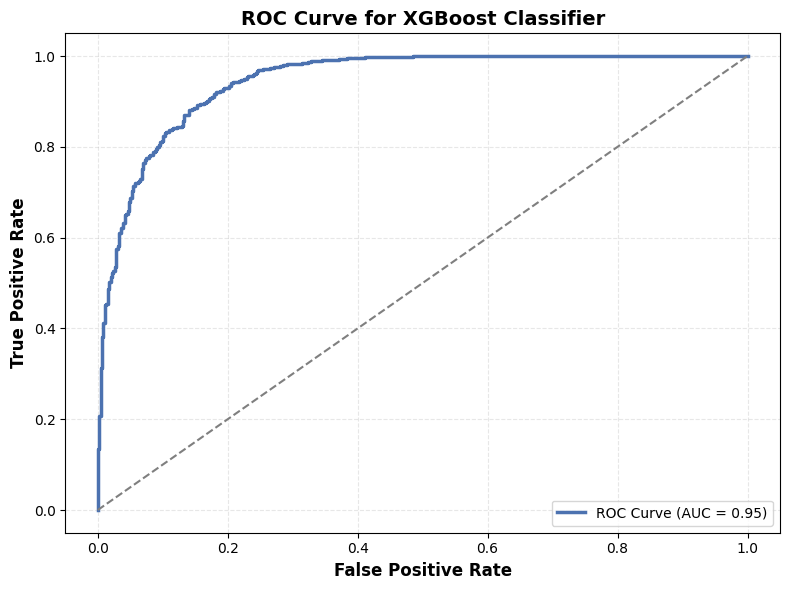

In [6]:
from xgboost import XGBClassifier

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include='object')),
    ('num', num_pipeline, selector(dtype_exclude='object'))
])

# Apply preprocessing
X_processed_oe = preprocessor.fit_transform(X)

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_oe, y, test_size=0.2, stratify=y, random_state=13)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Initialize and train XGBoost model
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1,
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid_search.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
xgb_model = grid_search.best_estimator_

# Call upon the evaluation function to assess XGBoost model performance
evaluate_model(xgb_model, X_test, y_test, X_full=X_processed_oe, y_full=y, title="XGBoost")